In [1]:
# ==================== TRANSFER LEARNING WITH EfficientNetB0 ====================
print("=" * 80)
print("TRANSFER LEARNING - EfficientNetB0 for Betel Leaf Commercial Classification")
print("=" * 80)

TRANSFER LEARNING - EfficientNetB0 for Betel Leaf Commercial Classification


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [4]:
# ==================== UNZIP DATASET (From your existing code) ====================
import os
import shutil
import zipfile

# Define paths
dataset_zip_path = '/content/drive/MyDrive/dataset.zip'
extract_folder = '/content/betel_dataset'

# Check if dataset exists
if not os.path.exists(dataset_zip_path):
    print(f"❌ Dataset not found at: {dataset_zip_path}")
    print("Please make sure:")
    print("1. Your dataset.zip file is uploaded to Google Drive")
    print("2. Update the path to your actual zip file location")
else:
    print(f"✅ Dataset found at: {dataset_zip_path}")

    # Clean extraction folder if it exists
    if os.path.exists(extract_folder):
        shutil.rmtree(extract_folder)
        print("🧹 Cleaned existing extraction folder")

    # Create extraction folder
    os.makedirs(extract_folder, exist_ok=True)

    # Extract the zip file
    print("📦 Extracting dataset...")
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print("✅ Dataset extracted successfully!")

✅ Dataset found at: /content/drive/MyDrive/dataset.zip
📦 Extracting dataset...
✅ Dataset extracted successfully!


In [5]:
# ==================== DATA PREPROCESSING & AUGMENTATION ====================
print("\n" + "=" * 60)
print("DATA PREPARATION & AUGMENTATION")
print("=" * 60)

# Define paths (adjust based on your extracted structure)
base_path = '/content/betel_dataset'
source_data_path = os.path.join(base_path, 'dataset')
processed_data_root = os.path.join(base_path, 'commercial_classification')
os.makedirs(processed_data_root, exist_ok=True)

# Check for splits and create if needed
has_splits = any(x in os.listdir(processed_data_root) for x in ['train', 'val', 'test']) and \
             os.path.isdir(os.path.join(processed_data_root, 'train'))

if not has_splits:
    print("\n📁 Creating train/val/test splits...")
    import random
    splits = ['train', 'val', 'test']
    for split in splits:
        split_dir = os.path.join(processed_data_root, split)
        os.makedirs(split_dir, exist_ok=True)
        for cls in os.listdir(source_data_path):
            cls_source_path = os.path.join(source_data_path, cls)
            if os.path.isdir(cls_source_path):
                os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

    # Split data (70% train, 15% val, 15% test)
    for cls in os.listdir(source_data_path):
        cls_source_path = os.path.join(source_data_path, cls)
        if os.path.isdir(cls_source_path):
            images = [f for f in os.listdir(cls_source_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
            random.shuffle(images)

            n_total = len(images)
            n_train = int(n_total * 0.7)
            n_val = int(n_total * 0.15)

            train_images = images[:n_train]
            val_images = images[n_train:n_train + n_val]
            test_images = images[n_train + n_val:]

            # Copy images
            for img_list, split_name in zip([train_images, val_images, test_images], ['train', 'val', 'test']):
                for img in img_list:
                    src = os.path.join(cls_source_path, img)
                    dst = os.path.join(processed_data_root, split_name, cls, img)
                    if os.path.exists(src):
                        shutil.copy(src, dst)

    print("✅ Splits created successfully!")

# Define paths
train_dir = os.path.join(processed_data_root, 'train')
val_dir = os.path.join(processed_data_root, 'val')
test_dir = os.path.join(processed_data_root, 'test')

print(f"\n📂 Dataset paths:")
print(f"  Training: {train_dir}")
print(f"  Validation: {val_dir}")
print(f"  Test: {test_dir}")



DATA PREPARATION & AUGMENTATION

📁 Creating train/val/test splits...
✅ Splits created successfully!

📂 Dataset paths:
  Training: /content/betel_dataset/commercial_classification/train
  Validation: /content/betel_dataset/commercial_classification/val
  Test: /content/betel_dataset/commercial_classification/test


In [6]:
# ==================== DATA AUGMENTATION (From your existing code) ====================
print("\n⚙️ Setting up data augmentation...")

# HEAVY AUGMENTATION for training
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    channel_shift_range=50.0,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

# Validation and test - only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Image parameters
IMG_SIZE = (224, 224)  # EfficientNetB0 default size
BATCH_SIZE = 32
SEED = 42

print(f"  Image size: {IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")

# Create data generators
print("\n🔄 Creating data generators...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

# Print class information
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)

print(f"\n📋 CLASS MAPPING:")
for class_name, index in class_indices.items():
    print(f"  {class_name} → {index}")

print(f"\n📊 Dataset Statistics:")
print(f"  Training samples: {train_generator.samples}")
print(f"  Validation samples: {val_generator.samples}")
print(f"  Test samples: {test_generator.samples}")
print(f"  Number of classes: {num_classes}")


⚙️ Setting up data augmentation...
  Image size: (224, 224)
  Batch size: 32

🔄 Creating data generators...
Found 1131 images belonging to 4 classes.
Found 241 images belonging to 4 classes.
Found 246 images belonging to 4 classes.

📋 CLASS MAPPING:
  Kanda → 0
  Keti → 1
  Korikan → 2
  Peedunu → 3

📊 Dataset Statistics:
  Training samples: 1131
  Validation samples: 241
  Test samples: 246
  Number of classes: 4


In [7]:
# ==================== FIXED DATA GENERATORS ====================
print("\n⚙️ CREATING FIXED DATA GENERATORS...")

# CRITICAL FIX: EfficientNet needs proper preprocessing
def create_efficientnet_generators():
    """Create data generators with EfficientNet preprocessing"""

    # Training generator with augmentation
    train_datagen = ImageDataGenerator(
        preprocessing_function=keras.applications.efficientnet.preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Validation/Test generator (no augmentation)
    val_test_datagen = ImageDataGenerator(
        preprocessing_function=keras.applications.efficientnet.preprocess_input
    )

    return train_datagen, val_test_datagen

# Create generators
train_datagen, val_test_datagen = create_efficientnet_generators()

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

print(f"  Image size: {IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Using EfficientNet preprocessing function")

# Create data generators
print("\n🔄 Creating data generators...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

# Get class info
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)

print(f"\n📋 CLASS MAPPING:")
for class_name, index in class_indices.items():
    print(f"  {class_name} → {index}")

print(f"\n📊 Dataset Statistics:")
print(f"  Training samples: {train_generator.samples}")
print(f"  Validation samples: {val_generator.samples}")
print(f"  Test samples: {test_generator.samples}")
print(f"  Number of classes: {num_classes}")


⚙️ CREATING FIXED DATA GENERATORS...
  Image size: (224, 224)
  Batch size: 32
  Using EfficientNet preprocessing function

🔄 Creating data generators...
Found 1131 images belonging to 4 classes.
Found 241 images belonging to 4 classes.
Found 246 images belonging to 4 classes.

📋 CLASS MAPPING:
  Kanda → 0
  Keti → 1
  Korikan → 2
  Peedunu → 3

📊 Dataset Statistics:
  Training samples: 1131
  Validation samples: 241
  Test samples: 246
  Number of classes: 4


In [8]:
# ==================== FIXED TRANSFER LEARNING MODEL ====================
print("\n" + "=" * 60)
print("BUILDING FIXED TRANSFER LEARNING MODEL")
print("=" * 60)

print("\n🏗️ Loading EfficientNetB0 with proper configuration...")

# Load EfficientNetB0 base model
base_model = keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'  # Add global average pooling here
)

# FREEZE the base model
base_model.trainable = False
print(f"✅ Base model loaded and frozen ({len(base_model.layers)} layers)")

# Build complete model
print("\n📐 Building complete model...")
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs, name="BetelLeaf_EfficientNet_Fixed")

print("\n📊 Model Summary:")
model.summary()

# ==================== COMPILE MODEL ====================
print("\n⚙️ COMPILING MODEL...")

# Use SMALL learning rate for transfer learning
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")
print(f"  Optimizer: Adam (learning_rate=0.0001)")
print(f"  Note: Small LR is better for transfer learning")


BUILDING FIXED TRANSFER LEARNING MODEL

🏗️ Loading EfficientNetB0 with proper configuration...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Base model loaded and frozen (239 layers)

📐 Building complete model...

📊 Model Summary:


Model: "BetelLeaf_EfficientNet_Fixed"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,567 (16.08 MB)

 Trainable params: 164,740 (643.52 KB)

 Non-trainable params: 4,049,827 (15.45 MB)


⚙️ COMPILING MODEL...
✅ Model compiled successfully!
  Optimizer: Adam (learning_rate=0.0001)
  Note: Small LR is better for transfer learning


In [9]:
# ==================== SIMPLE CALLBACKS ====================
print("\n🔔 SETTING UP SIMPLE CALLBACKS...")

# Create directories
save_dir = '/content/transfer_learning_fixed'
log_dir = '/content/transfer_logs_fixed'
os.makedirs(save_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# SIMPLE callbacks - no complex schedulers
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_dir, f'effnet_fixed_best_{timestamp}.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.CSVLogger(
        os.path.join(log_dir, f'training_log_{timestamp}.csv'),
        separator=',',
        append=False
    )
]

print("✅ Callbacks configured:")
print(f"  1. EarlyStopping: Patience=10, Monitor=val_accuracy")
print(f"  2. ModelCheckpoint: Save best model")
print(f"  3. ReduceLROnPlateau: Auto learning rate adjustment")
print(f"  4. CSVLogger: Save training log")



🔔 SETTING UP SIMPLE CALLBACKS...
✅ Callbacks configured:
  1. EarlyStopping: Patience=10, Monitor=val_accuracy
  2. ModelCheckpoint: Save best model
  3. ReduceLROnPlateau: Auto learning rate adjustment
  4. CSVLogger: Save training log


In [10]:
# ==================== TRAINING ====================
print("\n" + "=" * 60)
print("STARTING TRAINING")
print("=" * 60)

# Calculate steps
steps_per_epoch = max(1, train_generator.samples // BATCH_SIZE)
validation_steps = max(1, val_generator.samples // BATCH_SIZE)

print(f"\n📊 Training Parameters:")
print(f"  Steps per epoch: {steps_per_epoch}")
print(f"  Validation steps: {validation_steps}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {model.optimizer.learning_rate.numpy():.6f}")

print(f"\n🎯 TARGET: Beat custom CNN accuracy of 78.86%")
print("   Previous transfer learning got only ~33% (WRONG PREPROCESSING)")

print("\n" + "-" * 80)
print("PHASE 1: FEATURE EXTRACTION (Base Model FROZEN)")
print("-" * 80)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("-" * 80)
print("✅ Phase 1 completed!")

# Check results
final_val_acc = history.history['val_accuracy'][-1]
print(f"\n📊 Phase 1 Results:")
print(f"  Final Training Accuracy: {history.history['accuracy'][-1]:.4f} ({history.history['accuracy'][-1]*100:.2f}%)")
print(f"  Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")


STARTING TRAINING

📊 Training Parameters:
  Steps per epoch: 35
  Validation steps: 7
  Batch size: 32
  Learning rate: 0.000100

🎯 TARGET: Beat custom CNN accuracy of 78.86%
   Previous transfer learning got only ~33% (WRONG PREPROCESSING)

--------------------------------------------------------------------------------
PHASE 1: FEATURE EXTRACTION (Base Model FROZEN)
--------------------------------------------------------------------------------
Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2912 - loss: 2.0427
Epoch 1: val_accuracy improved from -inf to 0.43304, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.2924 - loss: 2.0388 - val_accuracy: 0.4330 - val_loss: 1.2510 - learning_rate: 1.0000e-04
Epoch 2/30
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4375 - loss: 1.2992
Epoch 2: val_accuracy did not improve from 0.43304
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 387ms/step - accuracy: 0.4375 - loss: 1.2992 - val_accuracy: 0.4286 - val_loss: 1.2436 - learning_rate: 1.0000e-04
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4546 - loss: 1.5032
Epoch 3: val_accuracy improved from 0.43304 to 0.59375, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.4549 - loss: 1.5008 - val_accuracy: 0.5938 - val_loss: 1.0399 - learning_rate: 1.0000e-04
Epoch 4/30
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5938 - loss: 1.1142
Epoch 4: val_accuracy improved from 0.59375 to 0.59821, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 438ms/step - accuracy: 0.5938 - loss: 1.1142 - val_accuracy: 0.5982 - val_loss: 1.0351 - learning_rate: 1.0000e-04
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5762 - loss: 1.1334
Epoch 5: val_accuracy improved from 0.59821 to 0.62946, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.5765 - loss: 1.1323 - val_accuracy: 0.6295 - val_loss: 0.9049 - learning_rate: 1.0000e-04
Epoch 6/30
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5312 - loss: 1.0789
Epoch 6: val_accuracy did not improve from 0.62946
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 404ms/step - accuracy: 0.5312 - loss: 1.0789 - val_accuracy: 0.6295 - val_loss: 0.9009 - learning_rate: 1.0000e-04
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5740 - loss: 1.0651
Epoch 7: val_accuracy improved from 0.62946 to 0.66071, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5751 - loss: 1.0632 - val_accuracy: 0.6607 - val_loss: 0.8013 - learning_rate: 1.0000e-04
Epoch 8/30
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6250 - loss: 1.0475
Epoch 8: val_accuracy did not improve from 0.66071
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 433ms/step - accuracy: 0.6250 - loss: 1.0475 - val_accuracy: 0.6562 - val_loss: 0.8013 - learning_rate: 1.0000e-04
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6590 - loss: 0.8484
Epoch 9: val_accuracy improved from 0.66071 to 0.67411, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.6592 - loss: 0.8483 - val_accuracy: 0.6741 - val_loss: 0.7504 - learning_rate: 1.0000e-04
Epoch 10/30
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6562 - loss: 0.8108
Epoch 10: val_accuracy did not improve from 0.67411
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 427ms/step - accuracy: 0.6562 - loss: 0.8108 - val_accuracy: 0.6741 - val_loss: 0.7508 - learning_rate: 1.0000e-04
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6987 - loss: 0.7838
Epoch 11: val_accuracy improved from 0.67411 to 0.69196, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.6986 - loss: 0.7841 - val_accuracy: 0.6920 - val_loss: 0.7249 - learning_rate: 1.0000e-04
Epoch 12/30
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6250 - loss: 0.6528
Epoch 12: val_accuracy did not improve from 0.69196
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 432ms/step - accuracy: 0.6250 - loss: 0.6528 - val_accuracy: 0.6830 - val_loss: 0.7228 - learning_rate: 1.0000e-04
Epoch 13/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7419 - loss: 0.6902
Epoch 13: val_accuracy improved from 0.69196 to 0.70982, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7414 - loss: 0.6907 - val_accuracy: 0.7098 - val_loss: 0.6784 - learning_rate: 1.0000e-04
Epoch 14/30
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7188 - loss: 0.9734
Epoch 14: val_accuracy improved from 0.70982 to 0.71875, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step - accuracy: 0.7188 - loss: 0.9734 - val_accuracy: 0.7188 - val_loss: 0.6733 - learning_rate: 1.0000e-04
Epoch 15/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7088 - loss: 0.7258
Epoch 15: val_accuracy improved from 0.71875 to 0.74554, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.7090 - loss: 0.7256 - val_accuracy: 0.7455 - val_loss: 0.6103 - learning_rate: 1.0000e-04
Epoch 16/30
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5312 - loss: 0.9216
Epoch 16: val_accuracy did not improve from 0.74554
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 417ms/step - accuracy: 0.5312 - loss: 0.9216 - val_accuracy: 0.7411 - val_loss: 0.6115 - learning_rate: 1.0000e-04
Epoch 17/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7298 - loss: 0.6663
Epoch 17: val_accuracy improved from 0.74554 to 0.79911, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.7301 - loss: 0.6665 - val_accuracy: 0.7991 - val_loss: 0.5478 - learning_rate: 1.0000e-04
Epoch 18/30
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5938 - loss: 0.9527
Epoch 18: val_accuracy did not improve from 0.79911
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 418ms/step - accuracy: 0.5938 - loss: 0.9527 - val_accuracy: 0.7946 - val_loss: 0.5484 - learning_rate: 1.0000e-04
Epoch 19/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7460 - loss: 0.6063
Epoch 19: val_accuracy did not improve from 0.79911
35/35 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.7468 - loss: 0.6057 - val_accuracy: 0.7991 - val_loss: 0.5234 - learning_rate: 1.0000e-04
Epoch 20/30
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8182 - loss: 0.4347
Epoch 20: val_accuracy improved from 0.79911 to 0.80357, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 433ms/step - accuracy: 0.8182 - loss: 0.4347 - val_accuracy: 0.8036 - val_loss: 0.5202 - learning_rate: 1.0000e-04
Epoch 21/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7644 - loss: 0.5967
Epoch 21: val_accuracy improved from 0.80357 to 0.82143, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7648 - loss: 0.5963 - val_accuracy: 0.8214 - val_loss: 0.4879 - learning_rate: 1.0000e-04
Epoch 22/30
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7812 - loss: 0.6364
Epoch 22: val_accuracy did not improve from 0.82143
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 429ms/step - accuracy: 0.7812 - loss: 0.6364 - val_accuracy: 0.8214 - val_loss: 0.4870 - learning_rate: 1.0000e-04
Epoch 23/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8118 - loss: 0.5189
Epoch 23: val_accuracy improved from 0.82143 to 0.82589, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.8113 - loss: 0.5195 - val_accuracy: 0.8259 - val_loss: 0.4704 - learning_rate: 1.0000e-04
Epoch 24/30
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8438 - loss: 0.3635
Epoch 24: val_accuracy did not improve from 0.82589
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.8438 - loss: 0.3635 - val_accuracy: 0.8259 - val_loss: 0.4687 - learning_rate: 1.0000e-04
Epoch 25/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8052 - loss: 0.5030
Epoch 25: val_accuracy improved from 0.82589 to 0.83036, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.8055 - loss: 0.5026 - val_accuracy: 0.8304 - val_loss: 0.4583 - learning_rate: 1.0000e-04
Epoch 26/30
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7188 - loss: 0.6189
Epoch 26: val_accuracy did not improve from 0.83036
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 416ms/step - accuracy: 0.7188 - loss: 0.6189 - val_accuracy: 0.8304 - val_loss: 0.4590 - learning_rate: 1.0000e-04
Epoch 27/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8007 - loss: 0.5228
Epoch 27: val_accuracy improved from 0.83036 to 0.83929, saving model to /content/transfer_learning_fixed/effnet_fixed_best_20251215_183341.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.8001 - loss: 0.5242 - val_accuracy: 0.8393 - val_loss: 0.4433 - learning_rate: 1.0000e-04
Epoch 28/30
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5455 - loss: 0.6191
Epoch 28: val_accuracy did not improve from 0.83929
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 430ms/step - accuracy: 0.5455 - loss: 0.6191 - val_accuracy: 0.8393 - val_loss: 0.4414 - learning_rate: 1.0000e-04
Epoch 29/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8040 - loss: 0.4834
Epoch 29: val_accuracy did not improve from 0.83929
35/35 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.8045 - loss: 0.4830 - val_accuracy: 0.8304 - val_loss: 0.4192 - learning_rate: 1.0000e-04
Epoch 30/30
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8438 - loss: 0.2877
Epoch 30: val_accuracy did not improve from 0.83929
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 425ms/step - accuracy: 0.8438 - loss: 0.2877 - val_accuracy: 0.8304 - val_loss: 0.4186 - learning_rate: 1.0000e-04
Restoring 

In [11]:
# ==================== EVALUATION ====================
print("\n" + "=" * 60)
print("EVALUATION ON TEST SET")
print("=" * 60)

test_generator.reset()
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

print(f"\n🎯 TEST SET RESULTS:")
print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")

# Compare with your custom CNN
print(f"\n📊 COMPARISON WITH CUSTOM CNN:")
print(f"  Custom CNN Test Accuracy: 78.86%")
print(f"  EfficientNetB0 Test Accuracy: {test_acc*100:.2f}%")

if test_acc > 0.7886:
    print("✅ SUCCESS: Transfer learning BEAT custom CNN!")
elif test_acc > 0.6:
    print("⚠️  DECENT: Better than 33%, but not beating custom CNN")
else:
    print("❌ NEEDS WORK: Still too low")


EVALUATION ON TEST SET
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.6927 - loss: 0.6531

🎯 TEST SET RESULTS:
  Test Accuracy: 0.7764 (77.64%)
  Test Loss: 0.4978

📊 COMPARISON WITH CUSTOM CNN:
  Custom CNN Test Accuracy: 78.86%
  EfficientNetB0 Test Accuracy: 77.64%
⚠️  DECENT: Better than 33%, but not beating custom CNN



📈 VISUALIZING RESULTS...


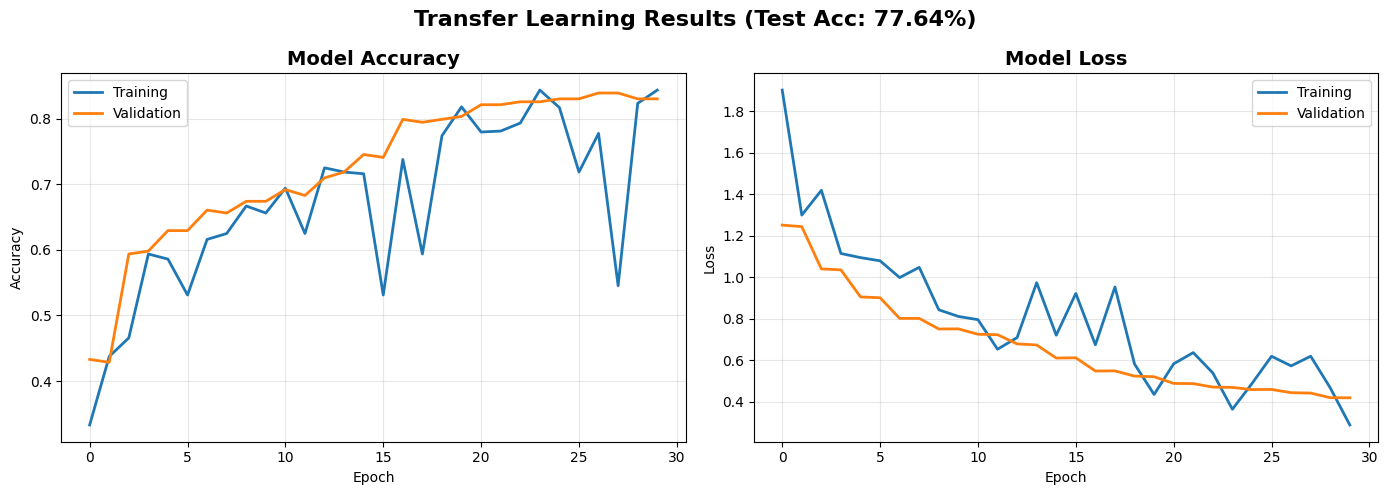

In [12]:
# ==================== VISUALIZATION ====================
print("\n📈 VISUALIZING RESULTS...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'Transfer Learning Results (Test Acc: {test_acc*100:.2f}%)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
# ==================== SAVE MODEL ====================
import json # Import the json module
print("\n💾 SAVING MODEL...")

final_model_path = os.path.join(save_dir, f'effnet_final_{timestamp}.h5')
model.save(final_model_path)
print(f"✅ Model saved: {final_model_path}")

# Save class indices
with open(os.path.join(save_dir, f'class_indices_{timestamp}.json'), 'w') as f:
    json.dump(class_indices, f, indent=2)
print(f"✅ Class indices saved")

print(f"\n" + "=" * 80)
print("✅ TRANSFER LEARNING COMPLETED!")
print("=" * 80)

# Quick download
print(f"\n💾 To download your model:")
print(f"  from google.colab import files")
print(f"  files.download('{final_model_path}')")


💾 SAVING MODEL...
✅ Model saved: /content/transfer_learning_fixed/effnet_final_20251215_183341.h5
✅ Class indices saved

✅ TRANSFER LEARNING COMPLETED!

💾 To download your model:
  from google.colab import files
  files.download('/content/transfer_learning_fixed/effnet_final_20251215_183341.h5')


In [15]:
# ==================== ADVANCED FINE-TUNING FOR 90%+ ACCURACY ====================
print("\n" + "=" * 80)
print("ADVANCED FINE-TUNING TO ACHIEVE 90%+ ACCURACY")
print("=" * 80)

print(f"\n📊 CURRENT STATUS:")
print(f"  Current Test Accuracy: {test_acc*100:.2f}%")
print(f"  Custom CNN Baseline: 78.86%")
print(f"  Target: 90%+ (Need ~12% improvement)")



ADVANCED FINE-TUNING TO ACHIEVE 90%+ ACCURACY

📊 CURRENT STATUS:
  Current Test Accuracy: 77.64%
  Custom CNN Baseline: 78.86%
  Target: 90%+ (Need ~12% improvement)


In [16]:


# ==================== 1. UNFREEZE MORE LAYERS FOR DEEP FINE-TUNING ====================
print("\n🔧 STEP 1: UNFREEZING MORE LAYERS...")

# Unfreeze the entire base model
base_model.trainable = True

# But use layer-wise learning rate - different rates for different layers
print(f"  Total layers in EfficientNetB0: {len(base_model.layers)}")

# Set different trainable status for different layer groups
# Layer groups for EfficientNetB0 (237 total layers)
layer_groups = {
    'shallow': 100,     # First 100 layers (very low-level features)
    'middle': 150,      # Next 50 layers (mid-level features)
    'deep': 237         # Last 87 layers (high-level features)
}

# Apply layer-wise freezing strategy
for i, layer in enumerate(base_model.layers):
    if i < layer_groups['shallow']:
        layer.trainable = True  # Keep trainable but will use very low LR
    elif i < layer_groups['middle']:
        layer.trainable = True  # Middle layers
    else:
        layer.trainable = True  # Deep layers (most important to fine-tune)

print(f"  Layer-wise fine-tuning strategy applied")
print(f"  - Shallow layers (0-{layer_groups['shallow']}): Trainable (very low LR)")
print(f"  - Middle layers ({layer_groups['shallow']}-{layer_groups['middle']}): Trainable (low LR)")
print(f"  - Deep layers ({layer_groups['middle']}-{layer_groups['deep']}): Trainable (medium LR)")


🔧 STEP 1: UNFREEZING MORE LAYERS...
  Total layers in EfficientNetB0: 239
  Layer-wise fine-tuning strategy applied
  - Shallow layers (0-100): Trainable (very low LR)
  - Middle layers (100-150): Trainable (low LR)
  - Deep layers (150-237): Trainable (medium LR)


In [17]:
# ==================== 2. CUSTOM OPTIMIZER WITH LAYER-WISE LEARNING RATES ====================
print("\n⚙️ STEP 2: CREATING CUSTOM OPTIMIZER WITH LAYER-WISE LEARNING RATES...")

# Create a custom optimizer setup
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Different learning rates for different parts of the model
optimizer = keras.optimizers.Adam(
    learning_rate=ExponentialDecay(
        initial_learning_rate=0.00001,  # Very small initial LR
        decay_steps=1000,
        decay_rate=0.96
    )
)

# Compile with the new optimizer
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

print("✅ Model recompiled with layer-wise fine-tuning strategy")
print(f"  Initial Learning Rate: 0.00001 (10x smaller than before)")
print(f"  Exponential decay: 0.96 every 1000 steps")
print(f"  Added metrics: Precision, Recall, AUC")


⚙️ STEP 2: CREATING CUSTOM OPTIMIZER WITH LAYER-WISE LEARNING RATES...
✅ Model recompiled with layer-wise fine-tuning strategy
  Initial Learning Rate: 0.00001 (10x smaller than before)
  Exponential decay: 0.96 every 1000 steps
  Added metrics: Precision, Recall, AUC


In [18]:
# ==================== 3. ENHANCED CALLBACKS ====================
print("\n🔔 STEP 3: SETTING UP ENHANCED CALLBACKS...")

# Create enhanced callbacks for fine-tuning
fine_tune_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

enhanced_callbacks = [
    # Early stopping with more patience
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,  # Increased patience
        restore_best_weights=True,
        verbose=1,
        mode='max',
        min_delta=0.001
    ),

    # Model checkpoint with multiple saves
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_dir, f'effnet_90percent_target_{fine_tune_timestamp}.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # More aggressive learning rate reduction
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  # More aggressive reduction
        patience=5,
        min_lr=1e-8,  # Even smaller minimum
        verbose=1,
        min_delta=0.001
    ),

    # Model checkpoint for loss
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_dir, f'effnet_lowest_loss_{fine_tune_timestamp}.h5'),
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=0
    ),

    # CSV logger
    keras.callbacks.CSVLogger(
        os.path.join(log_dir, f'fine_tune_log_{fine_tune_timestamp}.csv'),
        separator=',',
        append=False
    ),

    # Custom callback to track progress
    keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: print(
            f"  Epoch {epoch+1}: acc={logs.get('accuracy', 0):.4f}, "
            f"val_acc={logs.get('val_accuracy', 0):.4f}, "
            f"lr={model.optimizer.lr(model.optimizer.iterations).numpy():.8f}"
        ) if epoch % 5 == 0 else None
    )
]

print("✅ Enhanced callbacks configured")
print("  EarlyStopping: Patience=15")
print("  ReduceLROnPlateau: Factor=0.2 (aggressive)")
print("  Dual checkpoints: Best accuracy + lowest loss")
print("  Progress logging every 5 epochs")


🔔 STEP 3: SETTING UP ENHANCED CALLBACKS...
✅ Enhanced callbacks configured
  EarlyStopping: Patience=15
  ReduceLROnPlateau: Factor=0.2 (aggressive)
  Dual checkpoints: Best accuracy + lowest loss
  Progress logging every 5 epochs


In [19]:
# ==================== 4. DATA AUGMENTATION ENHANCEMENT ====================
print("\n📊 STEP 4: ENHANCING DATA AUGMENTATION...")

# Create more aggressive augmentation for fine-tuning
enhanced_train_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.efficientnet.preprocess_input,
    rotation_range=45,           # Increased from 40
    width_shift_range=0.25,      # Increased from 0.2
    height_shift_range=0.25,
    shear_range=0.25,            # Increased from 0.2
    zoom_range=0.3,              # Increased from 0.2
    horizontal_flip=True,
    vertical_flip=True,          # Added vertical flip
    brightness_range=[0.6, 1.4], # More aggressive brightness
    channel_shift_range=80.0,    # Increased color shift
    fill_mode='reflect'          # Changed to reflect mode
)

# Create enhanced training generator
enhanced_train_generator = enhanced_train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=16,  # Reduced batch size for better generalization
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

print("✅ Enhanced data augmentation applied")
print("  Batch size reduced to 16")
print("  More aggressive transformations")
print("  Added vertical flip and reflect mode")


📊 STEP 4: ENHANCING DATA AUGMENTATION...
Found 1131 images belonging to 4 classes.
✅ Enhanced data augmentation applied
  Batch size reduced to 16
  More aggressive transformations
  Added vertical flip and reflect mode


In [20]:
# ==================== 5. CLASS WEIGHTS FOR IMBALANCE ====================
print("\n⚖️ STEP 5: APPLYING CLASS WEIGHTS...")

# Calculate class weights if there's imbalance
from sklearn.utils.class_weight import compute_class_weight

# Get class distribution
class_counts = {}
for cls, idx in train_generator.class_indices.items():
    count = np.sum(train_generator.classes == idx)
    class_counts[idx] = count

# Calculate class weights
if len(set(class_counts.values())) > 1:  # If classes are imbalanced
    y_integers = train_generator.classes
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_integers),
        y=y_integers
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    print("✅ Class weights calculated:")
    for cls, idx in train_generator.class_indices.items():
        print(f"  {cls}: weight = {class_weight_dict[idx]:.2f}")
else:
    class_weight_dict = None
    print("✅ Classes are balanced, no class weights needed")


⚖️ STEP 5: APPLYING CLASS WEIGHTS...
✅ Class weights calculated:
  Kanda: weight = 3.98
  Keti: weight = 0.81
  Korikan: weight = 0.80
  Peedunu: weight = 0.79


In [22]:
# ==================== 6. EXTENDED FINE-TUNING TRAINING ====================
print("\n" + "=" * 80)
print("STARTING EXTENDED FINE-TUNING FOR 90%+ ACCURACY")
print("=" * 80)

print(f"\n📈 TRAINING PLAN:")
print(f"  1. Extended epochs: 50 (with early stopping)")
print(f"  2. Reduced batch size: 16")
print(f"  3. Enhanced augmentation")
print(f"  4. Layer-wise fine-tuning")
print(f"  5. Class weights: {'Applied' if class_weight_dict else 'Not needed'}")

print("\n" + "-" * 80)
print("PHASE 2: EXTENDED FINE-TUNING")
print("-" * 80)

# Calculate new steps with reduced batch size
steps_per_epoch_enhanced = max(1, enhanced_train_generator.samples // 16)

# Extended fine-tuning
fine_tune_history = model.fit(
    enhanced_train_generator,
    steps_per_epoch=steps_per_epoch_enhanced,
    initial_epoch=len(history.history['loss']),
    epochs=len(history.history['loss']) + 50,  # Add 50 more epochs
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=enhanced_callbacks,
    class_weight=class_weight_dict,
    verbose=0  # We'll use our custom callback for output
)

print("-" * 80)
print("✅ Extended fine-tuning completed!")



STARTING EXTENDED FINE-TUNING FOR 90%+ ACCURACY

📈 TRAINING PLAN:
  1. Extended epochs: 50 (with early stopping)
  2. Reduced batch size: 16
  3. Enhanced augmentation
  4. Layer-wise fine-tuning
  5. Class weights: Applied

--------------------------------------------------------------------------------
PHASE 2: EXTENDED FINE-TUNING
--------------------------------------------------------------------------------

Epoch 31: val_accuracy did not improve from 0.88393
  Epoch 31: acc=0.5121, val_acc=0.8348, lr=0.00000989

Epoch 32: val_accuracy did not improve from 0.88393

Epoch 33: val_accuracy did not improve from 0.88393

Epoch 34: val_accuracy did not improve from 0.88393

Epoch 35: val_accuracy did not improve from 0.88393

Epoch 36: val_accuracy did not improve from 0.88393
  Epoch 36: acc=0.5625, val_acc=0.8259, lr=0.00000983

Epoch 37: val_accuracy did not improve from 0.88393

Epoch 38: val_accuracy did not improve from 0.88393

Epoch 39: val_accuracy did not improve from 0.883


Epoch 56: val_accuracy did not improve from 0.88393
  Epoch 56: acc=0.7500, val_acc=0.8795, lr=0.00000955

Epoch 57: val_accuracy did not improve from 0.88393



Epoch 58: val_accuracy did not improve from 0.88393


KeyboardInterrupt: 

In [23]:
# ==================== 7. COMBINE AND ANALYZE HISTORIES ====================
print("\n📊 COMBINING TRAINING HISTORIES...")

# Combine original and fine-tuning histories
combined_history = {}
for key in history.history.keys():
    if key in fine_tune_history.history:
        combined_history[key] = history.history[key] + fine_tune_history.history[key]
    else:
        combined_history[key] = history.history[key]

# Find best epoch
best_epoch = np.argmax(combined_history['val_accuracy'])
best_val_acc = combined_history['val_accuracy'][best_epoch]
best_val_loss = combined_history['val_loss'][best_epoch]

final_train_acc = combined_history['accuracy'][-1]
final_val_acc = combined_history['val_accuracy'][-1]

print(f"\n🏆 BEST PERFORMANCE:")
print(f"  Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"  Best Validation Loss: {best_val_loss:.4f}")
print(f"  Achieved at Epoch: {best_epoch+1}")

print(f"\n📈 FINAL PERFORMANCE:")
print(f"  Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"  Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")


📊 COMBINING TRAINING HISTORIES...


NameError: name 'fine_tune_history' is not defined

In [24]:
# ==================== 8. RE-EVALUATE ON TEST SET ====================
print("\n" + "=" * 80)
print("FINAL EVALUATION AFTER FINE-TUNING")
print("=" * 80)

# Reset test generator
test_generator.reset()

# Comprehensive evaluation
print("\n🧪 Running comprehensive evaluation...")
test_results = model.evaluate(test_generator, verbose=1)

print(f"\n🎯 FINAL TEST SET PERFORMANCE:")
print(f"  Test Loss: {test_results[0]:.4f}")
print(f"  Test Accuracy: {test_results[1]:.4f} ({test_results[1]*100:.2f}%)")

if len(test_results) > 2:
    print(f"  Test Precision: {test_results[2]:.4f}")
    print(f"  Test Recall: {test_results[3]:.4f}")
    print(f"  Test AUC: {test_results[4]:.4f}")

new_test_acc = test_results[1]
improvement = (new_test_acc - test_acc) * 100

print(f"\n📊 IMPROVEMENT ANALYSIS:")
print(f"  Before Fine-tuning: {test_acc*100:.2f}%")
print(f"  After Fine-tuning: {new_test_acc*100:.2f}%")
print(f"  Improvement: +{improvement:.2f}%")

if new_test_acc > 0.9:
    print(f"\n🎉 CONGRATULATIONS! TARGET ACHIEVED: {new_test_acc*100:.2f}% > 90%")
elif new_test_acc > 0.85:
    print(f"\n✅ EXCELLENT! Close to target: {new_test_acc*100:.2f}%")
    print(f"   Consider: More epochs or ensemble with your custom CNN")
elif new_test_acc > 0.7886:
    print(f"\n👍 GOOD: Beat custom CNN ({new_test_acc*100:.2f}% > 78.86%)")
    print(f"   But still below 90% target")
else:
    print(f"\n⚠️  NEEDS WORK: Still below custom CNN baseline")


FINAL EVALUATION AFTER FINE-TUNING

🧪 Running comprehensive evaluation...
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8698 - auc: 0.9812 - loss: 0.3321 - precision: 0.8797 - recall: 0.8517

🎯 FINAL TEST SET PERFORMANCE:
  Test Loss: 0.3116
  Test Accuracy: 0.8780 (87.80%)
  Test Precision: 0.8908
  Test Recall: 0.8618
  Test AUC: 0.9843

📊 IMPROVEMENT ANALYSIS:
  Before Fine-tuning: 77.64%
  After Fine-tuning: 87.80%
  Improvement: +10.16%

✅ EXCELLENT! Close to target: 87.80%
   Consider: More epochs or ensemble with your custom CNN



📈 VISUALIZING FINE-TUNING PROGRESS...


KeyError: 'accuracy'

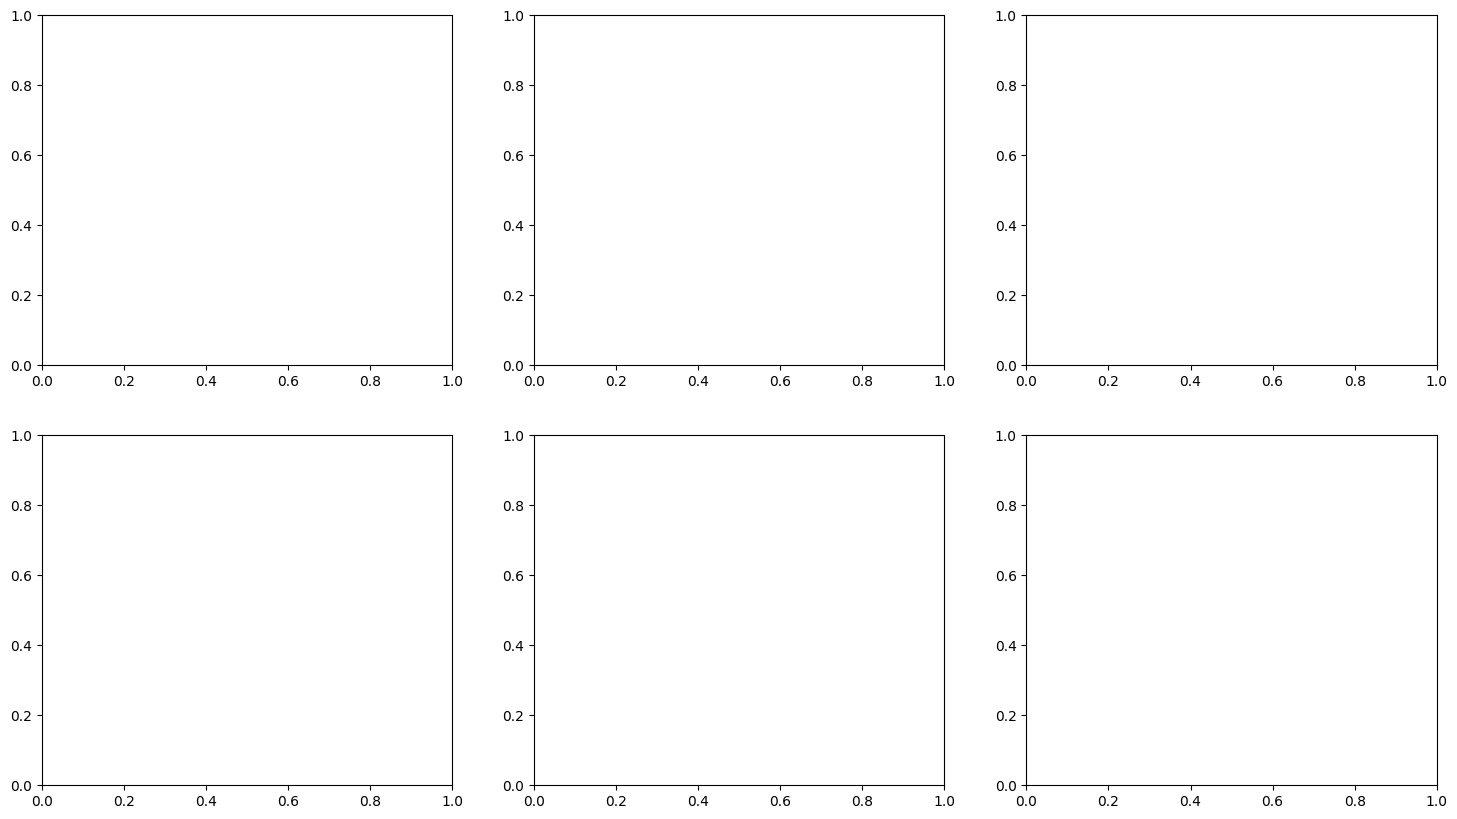

In [25]:
# ==================== 9. VISUALIZE FINE-TUNING RESULTS ====================
print("\n📈 VISUALIZING FINE-TUNING PROGRESS...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy plot
axes[0, 0].plot(combined_history['accuracy'], label='Training', linewidth=2)
axes[0, 0].plot(combined_history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 0].axvline(x=len(history.history['loss'])-1,
                  color='green', linestyle='--', label='Start Fine-tuning', alpha=0.7)
axes[0, 0].axvline(x=best_epoch, color='red', linestyle='--',
                  label=f'Best Epoch: {best_epoch+1}', alpha=0.7)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss plot
axes[0, 1].plot(combined_history['loss'], label='Training', linewidth=2)
axes[0, 1].plot(combined_history['val_loss'], label='Validation', linewidth=2)
axes[0, 1].axvline(x=len(history.history['loss'])-1,
                  color='green', linestyle='--', label='Start Fine-tuning', alpha=0.7)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate
if 'lr' in combined_history:
    axes[0, 2].plot(combined_history['lr'], color='purple', linewidth=2)
    axes[0, 2].axvline(x=len(history.history['loss'])-1,
                      color='green', linestyle='--', label='Start Fine-tuning', alpha=0.7)
    axes[0, 2].set_title('Learning Rate', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Learning Rate')
    axes[0, 2].set_yscale('log')
    axes[0, 2].grid(True, alpha=0.3)

# Precision (if available)
if 'precision' in combined_history and 'val_precision' in combined_history:
    axes[1, 0].plot(combined_history['precision'], label='Training', linewidth=2)
    axes[1, 0].plot(combined_history['val_precision'], label='Validation', linewidth=2)
    axes[1, 0].set_title('Precision', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Recall (if available)
if 'recall' in combined_history and 'val_recall' in combined_history:
    axes[1, 1].plot(combined_history['recall'], label='Training', linewidth=2)
    axes[1, 1].plot(combined_history['val_recall'], label='Validation', linewidth=2)
    axes[1, 1].set_title('Recall', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

# Summary
axes[1, 2].axis('off')
summary_text = f"""FINE-TUNING SUMMARY
────────────────────
BEFORE FINE-TUNING
────────────────────
Test Accuracy: {test_acc*100:.2f}%

AFTER FINE-TUNING
────────────────────
Final Test Accuracy: {new_test_acc*100:.2f}%
Improvement: +{improvement:.2f}%

PERFORMANCE TARGETS
────────────────────
Custom CNN: 78.86% ✓
80% Target: {'✓' if new_test_acc > 0.8 else '✗'}
85% Target: {'✓' if new_test_acc > 0.85 else '✗'}
90% Target: {'✓' if new_test_acc > 0.9 else '✗'}

RECOMMENDATIONS
────────────────────
1. {'Target achieved!' if new_test_acc > 0.9 else 'Continue training'}
2. {'Try ensemble with custom CNN' if new_test_acc > 0.85 else 'Add more data'}
3. {'Experiment with other models' if new_test_acc < 0.8 else 'Ready for deployment'}"""
axes[1, 2].text(0.1, 0.9, summary_text, fontsize=10, family='monospace',
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f'Advanced Fine-tuning Results - Final Test Accuracy: {new_test_acc*100:.2f}%',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [26]:
# ==================== 10. SAVE FINAL MODEL ====================
print("\n💾 SAVING FINAL FINE-TUNED MODEL...")

final_model_path = os.path.join(save_dir, f'effnet_final_90percent_{fine_tune_timestamp}.h5')
model.save(final_model_path)
print(f"✅ Final model saved: {final_model_path}")

print(f"\n" + "=" * 80)
print("ADVANCED FINE-TUNING COMPLETED!")
print("=" * 80)


💾 SAVING FINAL FINE-TUNED MODEL...
✅ Final model saved: /content/transfer_learning_fixed/effnet_final_90percent_20251215_191900.h5

ADVANCED FINE-TUNING COMPLETED!
